In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmdstanpy as cs
import arviz as az
from matplotlib import cm


class Gompertz:
    # Gompertz survival model
    def __init__(self, gamma, psi):
        self.gamma = gamma
        self.phi = psi
    def pdf(self, t):
        # probability density function
        pdf = (self.gamma * np.exp(self.phi * t)
               * np.exp(-self.gamma/self.phi * (np.exp(self.phi*t) - 1)))
        return pdf
    def hazard(self, t):
        # hazard function (linear)
        return np.log(self.gamma) + self.phi*t

def bspline(x, xh, delt):
    # knots
    xh1 = xh + 1 * delt
    xh2 = xh + 2 * delt
    xh3 = xh + 3 * delt
    xh4 = xh + 4 * delt
    bs = []
    for xx in x:
        if xh <= xx < xh1:
            u = (xx - xh) / delt
            bh = 1 / 6 * u ** 3
        elif xh1 <= xx < xh2:
            u = (xx - xh1) / delt
            bh = 1 / 6 * (1 + 3 * u + 3 * u ** 2 - 3 * u ** 3)
        elif xh2 <= xx < xh3:
            u = (xx - xh2) / delt
            bh = 1 / 6 * (4 - 6 * u ** 2 + 3 * u ** 3)
        elif xh3 <= xx < xh4:
            u = (xx - xh3) / delt
            bh = 1 / 6 * (1 - 3 * u + 3 * u ** 2 - u ** 3)
        else:
            bh = 0
        bs.append(bh)
    return np.array(bs)

def uniBspline(xx, H):
    delta = (xx.max() - xx.min()) / (H - 1)
    xhh = np.arange(xx.min() - (delta * 2), xx.max(), delta)[:-1]
    # functions
    splines = [lambda x, xh=xh: bspline(x, xh, delta) for xh in xhh]
    return splines

def PhiDM(x):
    return np.column_stack([np.ones_like(x), x])
def PsiDM(x, splines):
    return np.column_stack([spline(x) for spline in splines])


# Knowledge Transfer in Engineering Fleets
## Multi-level survival analysis based on an operational truck fleet

## Survival Analysis
A branch of statistics used to assess the expected duration until failure.
(Reliability theory or reliability analysis in engineering.)

- what proportion of assets will survive past a certain time?
- of the assets that survive, what rate will they fail? (hazard)
- what effects do certain operations or environment have of the probability
of survival?

### Why parametric survival models?

Interpretable - allow for actionable insight, especially at the
population level. For example, the Gompertz survival model (G):

\begin{align}
p(T=t) &= \textrm{G}(t\; ; \;\gamma, \phi) \\
&= (\gamma e^{\phi t}) \exp \left\{- \frac{\gamma}{\phi} (e^{\phi t} - 1)
\right\}
\end{align}

Distribution over $T$ - the time of failure

- $\gamma: \quad$ initial or base-line rate of failure (RoF)
- $\phi: \quad$ exponential coefficient for RoF

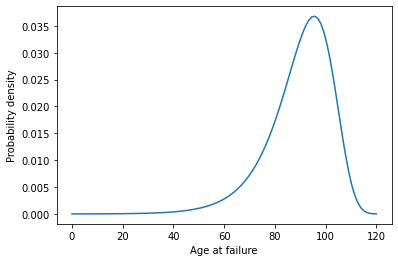

In [2]:
# total operational life
t = np.linspace(0, 120, 100)

# parameters of the Gompertz model
gamma = 7.12e-6
phi = 0.1

# the probability density function
GM = Gompertz(gamma, phi)
pdf = GM.pdf(t)

# plot
plt.figure()
plt.plot(t, pdf)
plt.xlabel('Age at failure')
plt.ylabel('Probability density')
plt.show()

### ...a parametric Hazard function

Hazard $H(t)$ is the instantaneous rate of failure (RoF), given that an
asset has survived so far (until $t$).

For the Gompertz model, this is linear:

$$
\log \mathbf{H} = \log(\gamma) + \phi \mathbf{t}
$$

which we rewrite with additive noise,

$$
\mathbf{y} = \boldsymbol{\Phi} \boldsymbol{\alpha} + \mathbf{\epsilon}
$$

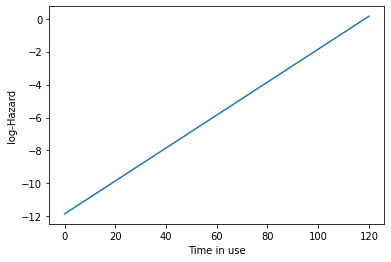

In [3]:
# plot the hazard for the same model
plt.figure()
Ht = GM.hazard(t)
plt.plot(t, Ht)
plt.xlabel('Time in use')
plt.ylabel('log-Hazard')
plt.show()

## Hazard in practice

Subgroups of the population/fleet with different survival models:
- vehicle use-types
- components

So the population model becomes:
$$
\bigg\{\mathbf{y}_k = \boldsymbol{\Phi}_k \boldsymbol{\alpha}_k  +
\mathbf{\epsilon}_k
\bigg\}_{k=1}^K
$$

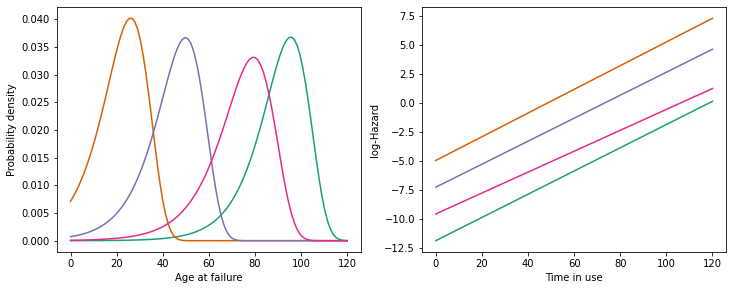

In [4]:
# parameters for different vehicle groups, component types, etc.
gamma = [7.12e-6, 7.12e-3, 7.12e-4, 7.12e-5]
phi = [0.1, 0.102, 0.099, 0.09]

# the model, pdf, and hazard for each group
GMs = [Gompertz(gamma[k], phi[k]) for k in range(4)]
PDFs = [gm.pdf(t) for gm in GMs]
Hts = [gm.hazard(t) for gm in GMs]

# plot
_, axs = plt.subplots(1,2, figsize=(12, 4.5))
cmap = cm.get_cmap('Dark2')
[axs[0].plot(t, PDFs[k], c=cmap(k)) for k in range(4)]
axs[0].set_xlabel('Age at failure')
axs[0].set_ylabel('Probability density')
[axs[1].plot(t, Hts[k], c=cmap(k)) for k in range(4)]
axs[1].set_xlabel('Time in use')
axs[1].set_ylabel('log-Hazard')
plt.show()

### More issues in practice...

Parametric models can be poorly representative. Consider the Scania data,
for example:

![image](figures/truck-hazard-data.png)

Here, we work with similar (normalised) hazard demo data:


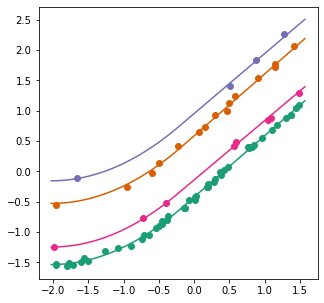

In [5]:
# training
t = np.load('data/sim-hazards/x.npy')       # age
y = np.load('data/sim-hazards/y.npy')       # hazard
c = np.load('data/sim-hazards/c.npy')       # group label
fk = np.load('data/sim-hazards/fk.npy')     # ground truth response
tt = np.load('data/sim-hazards/xx.npy')     # ground truth inputs
# test set (not in demo)
t_test = np.empty_like(t)
y_test = np.empty_like(y)
c_test = c.copy()
# plot
plt.figure(figsize=(5, 5))
[plt.scatter(t[c==k], y[c==k], color=cmap(k)) for k in range(4)]
[plt.plot(tt, fk[:, k], color=cmap(k)) for k in range(4)]
axs[1].set_xlabel('Time in use')
axs[1].set_ylabel('log-Hazard')
plt.show()

To model these hazard functions, the Gompertz linear model should be
modified. In this case, we add a non-parametric (b-spline) component:

$$
\bigg\{\mathbf{y}_k =\boldsymbol{\Phi}_k \boldsymbol{\alpha}_k +
\boldsymbol{\Psi}_k \boldsymbol{\beta}_k + \boldsymbol{\epsilon}_k
\bigg\}_{k=1}^K
$$

The new set of bases (and weights) model the nonlinear response in
the practical data - the discrepancy from the parametric model.

This is then a semiparametric or a partially-linear model, where:
- the interpretable/parametric component is $\boldsymbol{\Phi}_k \boldsymbol{\alpha}_k$
- the nonparametric discrepancy component is $\boldsymbol{\Psi}_k
\boldsymbol{\beta}_k$


In a Bayesian manner, we set priors over the latent variables (details in
the paper).

Using HMC (NUTS) in the probabilistic programming language STAN, we perform
inference considering the data-rich domain (green):


In [6]:
# instantiate
splineReg = cs.CmdStanModel(stan_file='stan-files/hzrd.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/lbull/OneDrive - The Alan Turing Institute/Documents/EngineeringPatternRecognition/stan-files/hzrd


In [7]:
# data rich domain
tk = t[c == 0]
yk = y[c == 0]
# test-set
tk_test = t_test[c == 0]
yk_test = y_test[c == 0]
ck_test = c_test[c == 0]

# splines
H = 5
splines = uniBspline(np.linspace(tt.min()-1, tt.max()+1, 100), H)
B = np.column_stack([spline(tt) for spline in splines])

# training-set via bases functions
Phi = PhiDM(tk)
Psi = PsiDM(tk, splines)
# test set
Phi_test = PhiDM(tk_test)
Psi_test = PsiDM(tk_test, splines)
# for plotting
Phi_tt = PhiDM(tt)
Psi_tt = PsiDM(tt, splines)

# stan inputs
data = {'Phi': Phi, 'Psi': Psi, 'N': Phi.shape[0], 'y': yk, 'H': len(splines),
        'Phi_test': Phi_test, 'Psi_test': Psi_test, 'y_test': yk_test,
        'Nt': Phi_test.shape[0], 'Nxx': Phi_tt.shape[0], 'Phi_xx': Phi_tt,
        'Psi_xx': Psi_tt}
# learn model
splReg = splineReg.sample(data=data, chains=4, max_treedepth=20,
                          adapt_delta=.99, iter_warmup=1000,
                          iter_sampling=2000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


INFO:cmdstanpy:Processing csv files: /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/hzrd-202203231715-1-rla8anaj.csv, /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/hzrd-202203231715-2-_vm5a5ms.csv, /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/hzrd-202203231715-3-3_2tqj4a.csv, /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/hzrd-202203231715-4-1i9gcgv4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


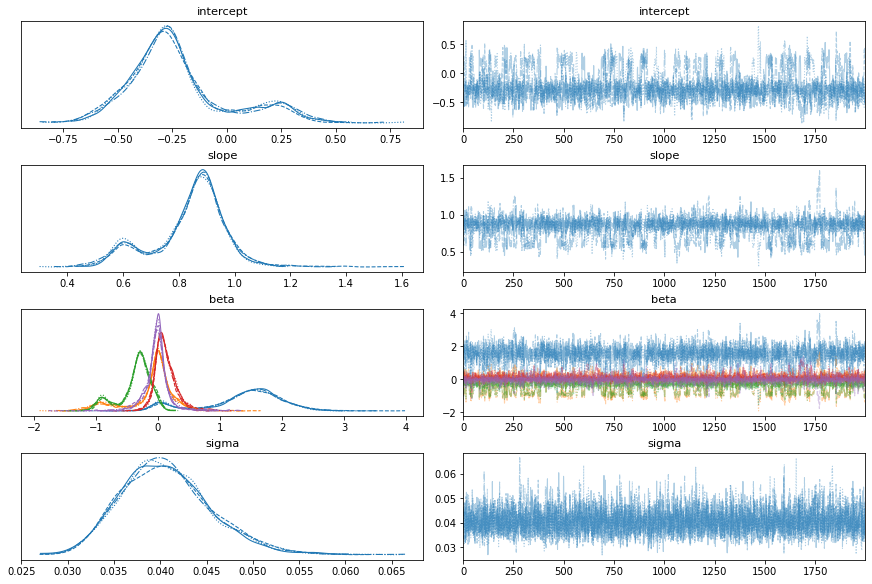

In [8]:
# summary/diagnosis
_ = splReg.diagnose()
# save vars / check traces
theta = splReg.stan_variables()
splRegAZ = az.from_cmdstanpy(splReg)
az.plot_trace(splRegAZ, var_names=['intercept', 'slope', 'beta', 'sigma'])
plt.show()

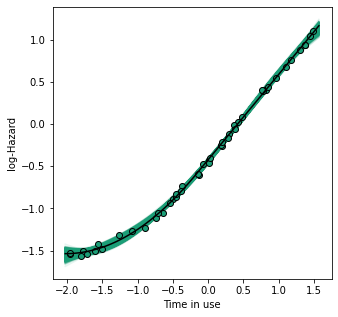

In [9]:
# plot the sampled functions
plt.figure(figsize=(5, 5))
plt.plot(tt, theta['yhat_xx'].T,
         color=cmap(0), alpha=.1, zorder=0)
plt.plot(tt, fk[:, 0], color='k')
plt.scatter(t[c==0], y[c==0], fc=cmap(0), ec='k')
plt.xlabel('Time in use')
plt.ylabel('log-Hazard')
plt.show()

## Why share information?
### Uncertainty in independent models

Learn the same (uncorrelated model) for each domain in turn...

In [10]:
# for the rest of the tasks...
thetak = [theta]
for k in range(1, 4):   # loop over the 4 tasks
    # data
    tk = t[c == k]
    yk = y[c == k]
    tk_test = t_test[c == k]
    yk_test = y_test[c == k]
    # via bases functions
    Phi = PhiDM(tk)
    Psi = PsiDM(tk, splines)
    # test set
    Phi_test = PhiDM(tk_test)
    Psi_test = PsiDM(tk_test, splines)
    # stan inputs
    data = {'Phi': Phi, 'Psi': Psi, 'N': Phi.shape[0], 'y': yk, 'H': len(splines),
            'Phi_test': Phi_test, 'Psi_test': Psi_test, 'y_test': yk_test,
            'Nt': Phi_test.shape[0], 'Nxx': Phi_tt.shape[0], 'Phi_xx': Phi_tt,
            'Psi_xx': Psi_tt}
    # learn the model
    splReg = splineReg.sample(data=data, chains=4, max_treedepth=20,
                              adapt_delta=.99, iter_warmup=1000,
                              iter_sampling=2000)
    _ = splReg.diagnose()
    thetak.append(splReg.stan_variables())

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:Processing csv files: /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/hzrd-202203231715-1-6536g68a.csv, /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/hzrd-202203231715-2-0yj6hlne.csv, /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/hzrd-202203231715-3-08peeu0c.csv, /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/hzrd-202203231715-4-byo3_l6j.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing comp

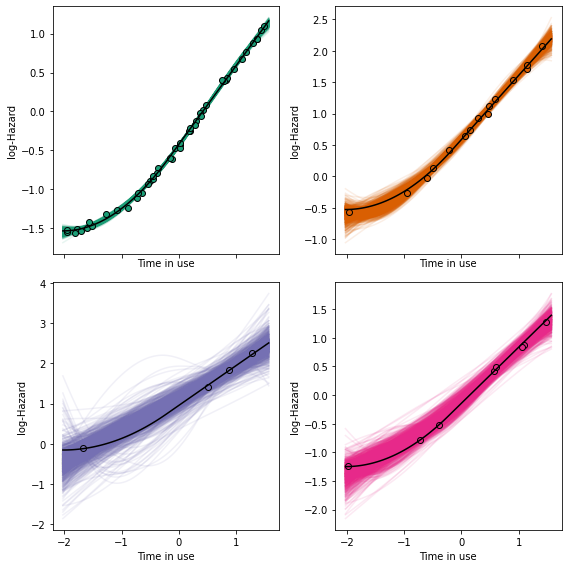

In [11]:
# plot K functions
_, axs = plt.subplots(2, 2, figsize=(8,8), sharex='all')
axs = axs.flatten()
for k in range(4):
    axs[k].plot(tt, thetak[k]['yhat_xx'][0:-1:10].T, alpha=.1,
                color=cmap(k), zorder=0)
    axs[k].plot(tt, fk[:, k], color='k')
    axs[k].scatter(t[c==k], y[c==k], fc=cmap(k), ec='k')
    axs[k].set_xlabel('Time in use')
    axs[k].set_ylabel('log-Hazard')
plt.tight_layout()
plt.show()

## A population-level analysis
### Hierarchical Bayes with Mixed-Effects

Separate (but correlated) regressions, learnt from each domain in a
_combined inference_

Varying:
- A similar, but _varied_ underlying linear trend: $\boldsymbol{\Phi}_k \boldsymbol{\alpha}_k$
- Correlate the linear component via (shared) parent nodes (priors)

Fixed:
- The nonlinear effects (and noise) appear consistent, shifted by the linear trend
- Infer the $\boldsymbol{\beta}$ (and $\epsilon_i$) at the population level
(parameter tying)

$$
\bigg\{\mathbf{y}_k =\underbrace{\boldsymbol{\Phi}_k \boldsymbol{\alpha}_k}_{\textrm{random}} + \underbrace{\boldsymbol{\Psi}_k \boldsymbol{\beta} + \boldsymbol{\epsilon}_k}_{\textrm{fixed}}
\bigg\}_{k=1}^K
$$

In [12]:
# instantiate population model
HBMEM = cs.CmdStanModel(stan_file='stan-files/pop-hzrd.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp96zl186k/tmpn_3vm8ss
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/lbull/OneDrive - The Alan Turing Institute/Documents/EngineeringPatternRecognition/stan-files/pop-hzrd


In [13]:
# collected data via bases functions
Phi = PhiDM(t)
Psi = PsiDM(t, splines)
# test set
Phi_test = PhiDM(t_test)
Psi_test = PsiDM(y_test, splines)

# stan inputs
data = {'Phi': Phi, 'Psi': Psi, 'N': Phi.shape[0], 'y': y, 'H': len(splines),
        'c': c+1, 'K': 4, 'Phi_test': Phi_test, 'Psi_test': Psi_test,
        'Nt': Phi_test.shape[0], 'y_test': y_test, 'c_test': c_test+1,
        'Phi_xx': Phi_tt, 'Psi_xx': Psi_tt, 'Nxx': Phi_tt.shape[0]}
# learn
popReg = HBMEM.sample(data=data, chains=4, max_treedepth=20,
                      adapt_delta=.99, iter_warmup=1000, iter_sampling=1000)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


INFO:cmdstanpy:Processing csv files: /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/pop-hzrd-202203231716-1-i6ypc287.csv, /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/pop-hzrd-202203231716-2-nrqkrkjs.csv, /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/pop-hzrd-202203231716-3-9odgnfth.csv, /var/folders/h6/d6pzq03x40336nq_xr5rvnfm0000gr/T/tmp1o2xpbz9/pop-hzrd-202203231716-4-b135ztqs.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


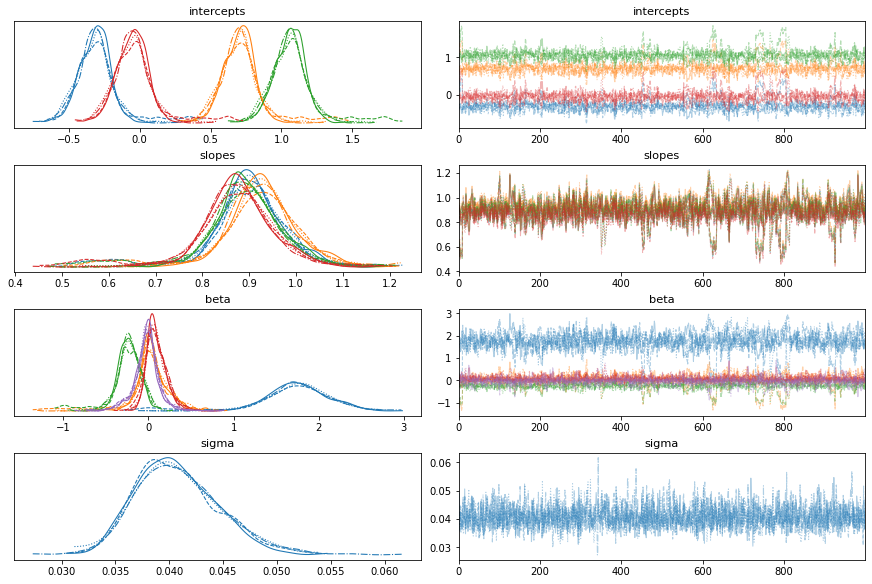

In [14]:
# summary/diagnosis
_ = popReg.diagnose()
# save vars / check traces
theta_p = popReg.stan_variables()
splRegAZ = az.from_cmdstanpy(popReg)
az.plot_trace(splRegAZ, var_names=['intercepts', 'slopes', 'beta', 'sigma'])
plt.show(block=False)

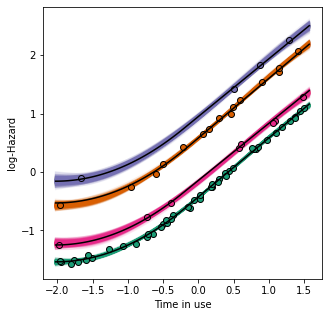

In [15]:
# plot predictive
plt.figure(figsize=(5, 5))
for k in range(4):
    # plot
    plt.plot(tt, theta_p['yhat_xx'][0:-1:10, :, k].T, alpha=.1, color=cmap(k),
             zorder=0)
    plt.scatter(t[c==k], y[c==k], fc=cmap(k), ec='k')
    plt.plot(tt, fk[:, k], color='k')
plt.xlabel('Time in use')
plt.ylabel('log-Hazard')
plt.show()

### Variance reduction in parameter estimates

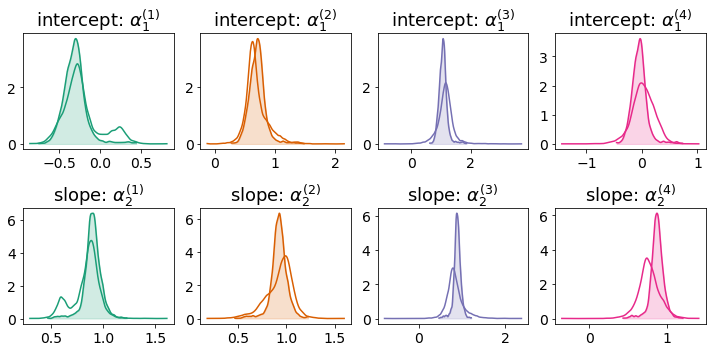

In [16]:
# variance reduction plots
_, axs = plt.subplots(2, 4, figsize=[10, 5])
axs = axs.flatten()
# alpha1
for k in range(4):
    # independent models
    az.plot_dist(thetak[k]['intercept'], ax=axs[k], color=cmap(k))
    # population model
    az.plot_dist(theta_p['intercepts'][:, k], ax=axs[k], color=cmap(k),
                 fill_kwargs={'alpha': 0.2})
    axs[k].set_title(r'intercept: $\alpha_1^{(%d)}$' % (k+1), size=18)
plt.tight_layout()
# alpha2
for k in range(4):
    # independent models
    az.plot_dist(thetak[k]['slope'], ax=axs[k+4], color=cmap(k))
    # population model
    az.plot_dist(theta_p['slopes'][:, k], ax=axs[k+4], color=cmap(k),
                 fill_kwargs={'alpha': 0.2})
    axs[k+4].set_title(r'slope: $\alpha_2^{(%d)}$' % (k+1), size=18)
plt.tight_layout()
plt.show()

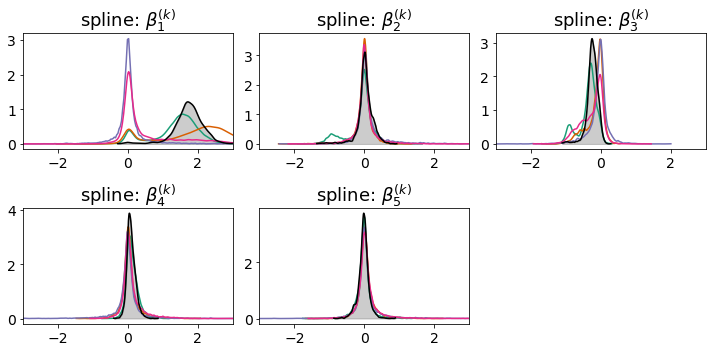

In [17]:
# betas (for knot h)
_, axs = plt.subplots(2, 3, figsize=[10, 5])
axs = axs.flatten()
for h in range(H):
    # independent models
    [az.plot_dist(thetak[k]['beta'][:, h], ax=axs[h], color=cmap(k))
     for k in range(4)]
    # population model
    az.plot_dist(theta_p['beta'][:, h], ax=axs[h],
                 color='k', fill_kwargs={'alpha': 0.2})
    axs[h].set_title(r'spline: $\beta^{(k)}_%d$' % (h + 1), size=18)
    axs[h].set_xlim([-3, 3])
axs[H].axis('off')

plt.tight_layout()
plt.show()

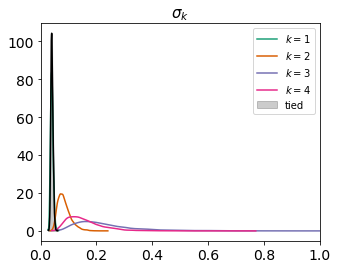

In [18]:
# sigma
_, ax = plt.subplots(figsize=[5, 4])
# independent models
[az.plot_dist(thetak[k]['sigma'], color=cmap(k), ax=ax,
              label=r'$k = %d$' % (k+1)) for k in range(4)]
# population model
az.plot_dist(theta_p['sigma'], color='k', ax=ax,
             fill_kwargs={'alpha': 0.2}, label='tied')
ax.set_xlim([0, 1])
ax.set_title(r'$\sigma_k$', size=15)
plt.show()